<a href="https://colab.research.google.com/github/suisanki/SML_team9/blob/main/modelSelection_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import math
import random
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, roc_curve, auc
import matplotlib.pyplot as plt
import xgboost

In [2]:
file_path = 'https://raw.githubusercontent.com/suisanki/SML_team9/main/data_banknote_authentication.csv'

df = pd.read_csv(file_path)
from sklearn.utils import resample
#Basically follow the instruction on page 15 of the "Day 4 Evaluation" file

#Use whole set of data to train & validate, find best hyper-parameters, and test to select one model.
#Check
print(df.shape)
print(df.head())
print(df.describe())
# print(df_rebalanced.shape)

#Creating the features dataset and target variable
X = df.drop('class', axis=1)  # Features
y = df['class']  # Target variable

#Setting 25% of data apart for testing. Temp data will be split to train and validation data later.
X_temp,X_test,y_temp,y_test = train_test_split(X,y,test_size = 0.25, random_state = 1)
#Reset index
X_temp = X_temp.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_temp = y_temp.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

(1372, 5)
   variance  skewness  curtosis  entropy  class
0   3.62160    8.6661   -2.8073 -0.44699      0
1   4.54590    8.1674   -2.4586 -1.46210      0
2   3.86600   -2.6383    1.9242  0.10645      0
3   3.45660    9.5228   -4.0112 -3.59440      0
4   0.32924   -4.4552    4.5718 -0.98880      0
          variance     skewness     curtosis      entropy        class
count  1372.000000  1372.000000  1372.000000  1372.000000  1372.000000
mean      0.433735     1.922353     1.397627    -1.191657     0.444606
std       2.842763     5.869047     4.310030     2.101013     0.497103
min      -7.042100   -13.773100    -5.286100    -8.548200     0.000000
25%      -1.773000    -1.708200    -1.574975    -2.413450     0.000000
50%       0.496180     2.319650     0.616630    -0.586650     0.000000
75%       2.821475     6.814625     3.179250     0.394810     1.000000
max       6.824800    12.951600    17.927400     2.449500     1.000000


In [3]:
#Diving the temp_data further into training and validation datasets
X_train_em,X_val_em,y_train_em,y_val_em = train_test_split(X_temp,y_temp,test_size = 0.33, random_state=1)

In [4]:
#Using Voting Classifier model to create an ensemble model of KNN, SVC and Decision Tree methods.

knn_clf = KNeighborsClassifier()
svc_clf = SVC(random_state=42,probability=True)
dt_clf = DecisionTreeClassifier(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('svc', svc_clf), ('dt', dt_clf), ('knn', knn_clf)],
    voting='soft'
)

#Set possible parameters.
param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': [0.1, 1, 10],
    'dt__max_depth': [2, 5, 10],
    'dt__min_samples_split': [2, 5, 10],
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance']
}

#Use recall (= sensitivity) (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score)
#Using Grid Search method to find the best parameters for the different methods in the ensemble model
grid_search = GridSearchCV(estimator=voting_clf, param_grid=param_grid, cv=5, scoring='recall', verbose=1)
grid_search.fit(X_train_em, y_train_em)

best_clf = grid_search.best_estimator_
print("Best parameters found:", grid_search.best_params_)
validation_accuracy = best_clf.score(X_val_em, y_val_em)
print("Validation set accuracy: {:.2f}".format(validation_accuracy))


Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Best parameters found: {'dt__max_depth': 2, 'dt__min_samples_split': 2, 'knn__n_neighbors': 3, 'knn__weights': 'uniform', 'svc__C': 0.1, 'svc__gamma': 0.1}
Validation set accuracy: 0.99


In [5]:
#Fitting Random Forest and XGBoost model to the train data
rf =  RandomForestRegressor
xgb = xgboost.XGBRegressor

max_depth_array = np.arange(2,21,1)
rf_recall_mean = []
rf_recall_std = []
xgb_recall_mean = []
xgb_recall_std = []

#Finding the best maximum depth for both the models by iterating through different data splits and at each depth and plotting the mean
#Recall score with standard deviation for each depth

# Define number of iterations
num_iterations = 10

# Loop through max_depth values
for depth in max_depth_array:
    rf_recall_scores = []
    xgb_recall_scores = []

    for i in range(num_iterations):
      X_train,X_val,y_train,y_val = train_test_split(X_temp,y_temp,test_size = 0.33, random_state = i)

      # Random Forest Regressor
      rf_model = rf(max_depth=depth)
      rf_model.fit(X_train, y_train)
      rf_pred = rf_model.predict(X_val)
      #Standardize the result to scale to probability
      rf_pred_std = (rf_pred - rf_pred.min()) / (rf_pred.max() - rf_pred.min())
      #Binarize the result using threshold of 0.5
      rf_pred_bin = [1 if p > 0.5 else 0 for p in rf_pred_std]
      recall = recall_score(y_val,rf_pred_bin)
      rf_recall_scores.append(recall)

      # XGBoost Regressor
      xgb_model = xgb(max_depth=depth)
      xgb_model.fit(X_train, y_train)
      xgb_pred = xgb_model.predict(X_val)
      #Standardize the result to scale to probability
      xgb_pred_std = (xgb_pred - xgb_pred.min()) / (xgb_pred.max() - xgb_pred.min())
      #Binarize the result using threshold of 0.5
      xgb_pred_bin = [1 if p > 0.5 else 0 for p in xgb_pred_std]
      recall = recall_score(y_val,xgb_pred_bin)
      xgb_recall_scores.append(recall)

    rf_recall_mean.append(np.mean(rf_recall_scores))
    rf_recall_std.append(np.std(rf_recall_scores))
    xgb_recall_mean.append(np.mean(xgb_recall_scores))
    xgb_recall_std.append(np.std(xgb_recall_scores))

In [6]:
print(xgb_recall_mean)
print(xgb_recall_std)

[0.9986707746478872, 0.9900528039575353, 0.9785567067762424, 0.9732441936439686, 0.9686883398364852, 0.9635733936040498, 0.9635733936040498, 0.9649527039488774, 0.9649527039488774, 0.9649527039488774, 0.9649527039488774, 0.9649527039488774, 0.9649527039488774, 0.9649527039488774, 0.9649527039488774, 0.9649527039488774, 0.9649527039488774, 0.9649527039488774, 0.9649527039488774]
[0.0026643467170927894, 0.013584441800043099, 0.013078056001638225, 0.010228322245054393, 0.012053408564750453, 0.011743221132128848, 0.011743221132128848, 0.014086802158103694, 0.014086802158103694, 0.014086802158103694, 0.014086802158103694, 0.014086802158103694, 0.014086802158103694, 0.014086802158103694, 0.014086802158103694, 0.014086802158103694, 0.014086802158103694, 0.014086802158103694, 0.014086802158103694]


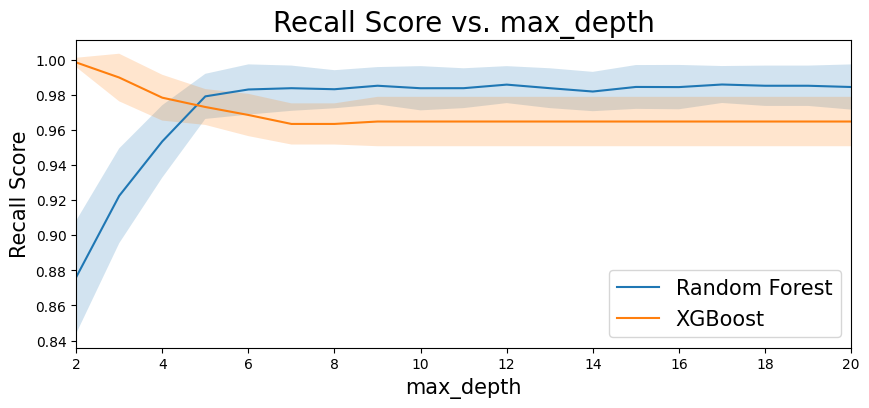

In [7]:
plt.figure(figsize=(10,4))
plt.plot(max_depth_array, rf_recall_mean, label='Random Forest')

plt.plot(max_depth_array, xgb_recall_mean, label='XGBoost')
rf_error = np.array(rf_recall_std)
xgb_error = np.array(xgb_recall_std)

plt.fill_between(max_depth_array, rf_recall_mean-rf_error,rf_recall_mean+rf_error, alpha = 0.2)
plt.fill_between(max_depth_array, xgb_recall_mean-xgb_error, xgb_recall_mean+xgb_error, alpha = 0.2)
plt.xlabel('max_depth',size=15)
plt.ylabel('Recall Score',size=15)
plt.title('Recall Score vs. max_depth', size=20)
plt.xlim([2,20])
plt.legend(fontsize = 15,loc="lower right")
plt.show()

In [8]:
print(xgb_recall_scores)

[0.9533333333333334, 0.9625, 0.9487179487179487, 0.9856115107913669, 0.971830985915493, 0.9490445859872612, 0.958904109589041, 0.9602649006622517, 0.9662162162162162, 0.993103448275862]


Can we interpret the model using global methods? Let's draw PDP plot.

# ROC Curves

In [9]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
X_train_em,X_val_em,y_train_em,y_val_em = train_test_split(X_temp,y_temp,test_size = 0.30, random_state = 1)

In [10]:
clf_rf = RandomForestRegressor(max_depth=6).fit(X_train_em, y_train_em) #Best Recall Score for Random Forest at max_depth = 6
clf_xgb = xgb(max_depth=2).fit(X_train_em, y_train_em) #Best Recall Score for XGBoost at max_depth = 2

# Voting classifier fitted with the best parameters obtained from the Grid Search
# Voting Classifier 'Ensemble' Best Parameters (at time of running):
# {'dt__max_depth': 2, 'dt__min_samples_split': 2, 'knn__n_neighbors': 3, 'knn__weights': 'uniform', 'svc__C': 0.1, 'svc__gamma': 0.1}
clf_voting = best_clf.fit(X_train_em, y_train_em) # best_clf is grid_search.best_estimator_

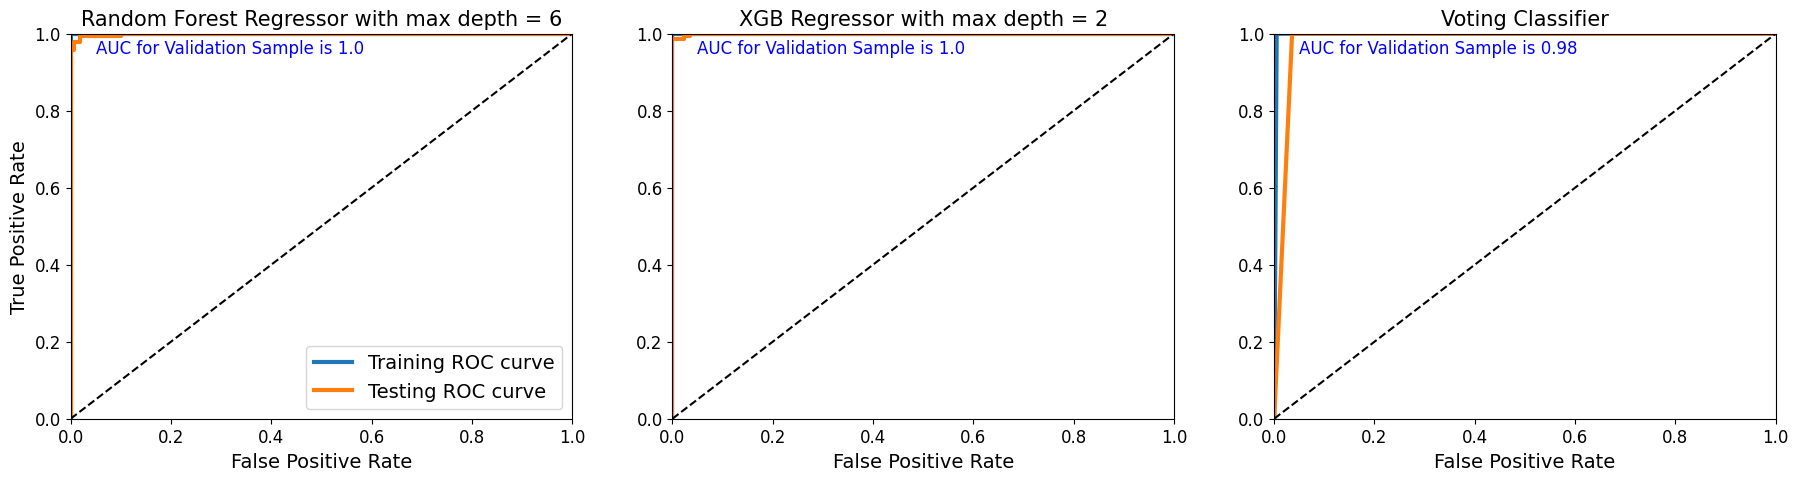

In [11]:
classifiers = [clf_rf, clf_xgb, clf_voting]
names = ['Random Forest Regressor with max depth = 6', 'XGB Regressor with max depth = 2', 'Voting Classifier']
i = 0
plt.figure(figsize = (22,5))
for name, clf in zip(names, classifiers):
  if clf == clf_rf or clf == clf_xgb:
    pred_train = clf.predict(X_train_em)
    pred_val = clf.predict(X_val_em)
  else:
    vce_train = clf.predict(X_train_em)
    vce_val = clf.predict(X_val_em)
    vce_train_stand = (vce_train - vce_train.min()) / (vce_train.max() - vce_train.min())
    pred_train = [1 if p > 0.5 else 0 for p in vce_train_stand]
    vce_val_stand = (vce_val - vce_val.min()) / (vce_val.max() - vce_val.min())
    pred_val = [1 if p > 0.5 else 0 for p in vce_val_stand]
  fpr_train, tpr_train, thresholds = roc_curve(y_train_em, pred_train)
  fpr_test, tpr_test, thresholds = roc_curve(y_val_em, pred_val)
  plt.subplot(1,3,i+1)
  plt.plot(fpr_train, tpr_train, label = 'Training ROC curve', lw = 3)
  plt.plot(fpr_test, tpr_test, label = 'Testing ROC curve', lw = 3)
  plt.axline((0,0), slope= 1, linestyle = 'dashed', color = 'black')
  plt.title(name, size = 15, loc = 'center', wrap = True)
  plt.xlabel('False Positive Rate', size = 14)
  if i == 0:
    plt.ylabel('True Positive Rate', size = 14)
    plt.legend(loc = 4, fontsize = 14)
  plt.xlim(0,1)
  plt.ylim(0,1)
  plt.xticks(size = 12)
  plt.yticks(size = 12)
  auc_test = round(auc(fpr_test, tpr_test),2)
  plt.text(0.05, 0.95, 'AUC for Validation Sample is ' + str(auc_test), fontsize = 12, color = 'blue')
  i += 1

# Evaluation

In [12]:
# from sklearn.metrics import roc_curve, auc
# from sklearn.calibration import calibration_curve
# from sklearn.metrics import accuracy_score
from sklearn.utils import resample

vce_scores = []
rfr_scores = []
xgb_scores = []
# Bootstrap the test data set
num_bootstraps = 25
for i in range(num_bootstraps):
  x_boot, y_boot = resample(X_test, y_test, random_state = i)

  # Best Voting Classifier on test data
  clf_voting = best_clf.fit(X_temp, y_temp)
  vce_test = clf_voting.predict(x_boot)
  vce_test_stand = (vce_test - vce_test.min()) / (vce_test.max() - vce_test.min())
  vce_pred_binary = [1 if p > 0.5 else 0 for p in vce_test_stand]
  recall = recall_score(y_boot, vce_pred_binary)
  vce_scores.append(recall)

  # Best Random Forest on test data
  clf_rfr = rf(max_depth=6).fit(X_temp, y_temp)
  rfr_test = clf_rfr.predict(x_boot)
  rfr_test_stand = (rfr_test - rfr_test.min()) / (rfr_test.max() - rfr_test.min())
  rfr_pred_binary = [1 if p > 0.5 else 0 for p in rfr_test_stand]
  recall = recall_score(y_boot, rfr_pred_binary)
  rfr_scores.append(recall)

  # Best XGBoost Depth fitted on the test data
  clf_xgb = xgb(max_depth=2).fit(X_temp, y_temp)
  xgb_test = clf_xgb.predict(x_boot)
  xgb_pred_stand = (xgb_test - xgb_test.min()) / (xgb_test.max() - xgb_test.min())
  xgb_pred_binary = [1 if p > 0.5 else 0 for p in xgb_pred_stand]
  recall = recall_score(y_boot, xgb_pred_binary)
  xgb_scores.append(recall)

print('VCE: min:', np.min(vce_scores), '; max:', np.max(vce_scores), '; mean:', np.mean(vce_scores), '; std:', np.std(vce_scores), '; 95%:', np.percentile(vce_scores, 95))
print('RFR: min:', np.min(rfr_scores), '; max:', np.max(rfr_scores), '; mean:', np.mean(rfr_scores), '; std:', np.std(rfr_scores), '; 95%:', np.percentile(rfr_scores, 95))
print('XGB: min:', np.min(xgb_scores), '; max:', np.max(xgb_scores), '; mean:', np.mean(xgb_scores), '; std:', np.std(xgb_scores), '; 95%:', np.percentile(xgb_scores, 95))

VCE: min: 1.0 ; max: 1.0 ; mean: 1.0 ; std: 0.0 ; 95%: 1.0
RFR: min: 0.9844961240310077 ; max: 1.0 ; mean: 0.9947388319816874 ; std: 0.005409804346017844 ; 95%: 1.0
XGB: min: 1.0 ; max: 1.0 ; mean: 1.0 ; std: 0.0 ; 95%: 1.0


VCE and XGB both performs well, but XGB score sometime is below 1.0.
**Let's use VCE**

In [13]:
#Building dataset from

#File path for real data
file_path1 = 'https://raw.githubusercontent.com/suisanki/SML_team9/main/ownData/real_r.csv'
#File path for fake data
file_path2 = 'https://raw.githubusercontent.com/suisanki/SML_team9/main/ownData/fake_r_c.csv'

data_real = pd.read_csv(file_path1)
data_fake = pd.read_csv(file_path2)

#Concat to make dataset where real vs fake = 1:1
_full_data = pd.concat([data_real,data_fake],ignore_index = True)
X_even = _full_data.drop('Flag', axis=1)
y_even = _full_data['Flag']

#Rebalance Real vs Fake to be 9:1 (Total real datapoints = 628)
_reb_real = data_real.sample(n=565, random_state=35)
_reb_fake = data_fake.sample(n=63, random_state=42)

_reb_data = pd.concat([_reb_real,_reb_fake],ignore_index = True)
X_reb = _reb_data.drop('Flag',axis=1)
y_reb = _reb_data["Flag"]

print(_full_data.describe())
print(_reb_data.describe())

                ID      Variance     Skewness     Curtosis      Entropy  \
count  1250.000000   1250.000000  1250.000000  1250.000000  1250.000000   
mean    624.500000   9791.371721    -0.988436     0.376621    14.866072   
std     360.988227   5467.478890     0.350477     1.003952     0.061105   
min       0.000000    334.333774    -2.269924    -1.256922    14.027108   
25%     312.250000   4673.482749    -1.203761    -0.364212    14.845163   
50%     624.500000   9826.957282    -0.976169     0.189604    14.866982   
75%     936.750000  14564.720802    -0.755581     0.836324    14.892721   
max    1249.000000  21247.598858    -0.015463     5.940053    14.950154   

              Flag  
count  1250.000000  
mean      0.497600  
std       0.500194  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000  
                ID      Variance    Skewness    Curtosis     Entropy  \
count   628.000000    628.000000  628.000000  628.000000  628.0

[1.0, 0.9905660377358491, 1.0, 1.0, 1.0, 0.9949494949494949, 0.9897435897435898, 1.0, 1.0, 0.995260663507109, 1.0, 0.9903846153846154, 0.9952380952380953, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Text(0.5, 1.0, 'Recall Score for different bootstrapped samples')

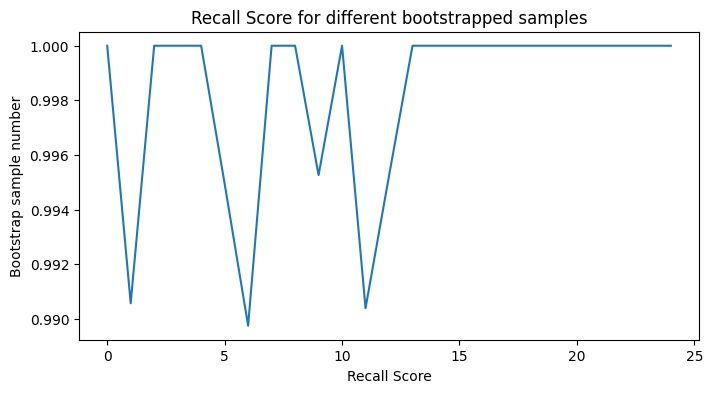

In [14]:
knn_clf = KNeighborsClassifier(n_neighbors=3,weights='uniform')
svc_clf = SVC(C=0.1,gamma=0.1,random_state=32,probability=True)
dt_clf = DecisionTreeClassifier(max_depth = 2, min_samples_split=2,random_state=44)

best_voting_clf = VotingClassifier(
    estimators=[('svc', svc_clf), ('dt', dt_clf), ('knn', knn_clf)],
    voting='soft'
)

vce_scores_even = []
num_bootstraps = 25

#Fit and Test with boot-strapped even data
for i in range(num_bootstraps):
  X_boot, y_boot = resample(X_even, y_even, random_state = i)
  X_train,X_test,y_train,y_test = train_test_split(X_boot,y_boot,test_size = 0.33, random_state = i)

  best_voting_clf.fit(X_train,y_train)
  vce_test = best_voting_clf.predict(X_test)
  vce_test_stand = (vce_test - vce_test.min()) / (vce_test.max() - vce_test.min())
  vce_pred_binary = [1 if p > 0.5 else 0 for p in vce_test_stand]
  recall = recall_score(y_test, vce_pred_binary)
  vce_scores_even.append(recall)

print(vce_scores_even)
plt.figure(figsize=(8,4))
plt.plot(vce_scores_even)
plt.xlabel('Recall Score')
plt.ylabel('Bootstrap sample number')
plt.title('Recall Score for different bootstrapped samples')

**Seems it's performing quite well with our own data too!**

[0.95, 0.9047619047619048, 1.0, 0.8181818181818182, 1.0, 0.9523809523809523, 0.8846153846153846, 1.0, 1.0, 0.9473684210526315, 1.0, 1.0, 0.9545454545454546, 0.9545454545454546, 0.9444444444444444, 1.0, 0.9090909090909091, 1.0, 1.0, 0.7727272727272727, 0.9444444444444444, 1.0, 0.9090909090909091, 1.0, 0.8571428571428571]


Text(0.5, 1.0, 'Recall Score for different bootstrapped samples')

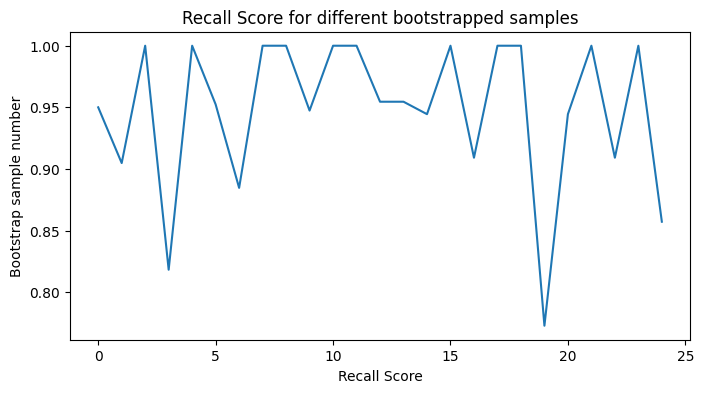

In [15]:
#Now, do the same with re-baalnced uneven data
vce_scores_reb = []
for i in range(num_bootstraps):
  X_boot, y_boot = resample(X_reb, y_reb, random_state = i)
  X_train,X_test,y_train,y_test = train_test_split(X_boot,y_boot,test_size = 0.33, random_state = i)

  best_voting_clf.fit(X_train,y_train)
  vce_test = best_voting_clf.predict(X_test)
  vce_test_stand = (vce_test - vce_test.min()) / (vce_test.max() - vce_test.min())
  vce_pred_binary = [1 if p > 0.5 else 0 for p in vce_test_stand]
  recall = recall_score(y_test, vce_pred_binary)
  vce_scores_reb.append(recall)

print(vce_scores_reb)
plt.figure(figsize=(8,4))
plt.plot(vce_scores_reb)
plt.xlabel('Recall Score')
plt.ylabel('Bootstrap sample number')
plt.title('Recall Score for different bootstrapped samples')

**More variance in the result when data is uneven. Let's calibrate the model**

In [16]:
vce_scores_reb_cali = []
#Try above again with calibrated model
clf_cali = CalibratedClassifierCV(best_voting_clf,method="isotonic")
for i in range(num_bootstraps):
  X_boot, y_boot = resample(X_reb, y_reb)
  X_train,X_test,y_train,y_test = train_test_split(X_boot,y_boot,test_size = 0.33, random_state = i)

  clf_cali.fit(X_train,y_train)
  vce_test = best_voting_clf.predict(X_test)
  vce_test_stand = (vce_test - vce_test.min()) / (vce_test.max() - vce_test.min())
  vce_pred_binary = [1 if p > 0.5 else 0 for p in vce_test_stand]
  recall = recall_score(y_test, vce_pred_binary)
  vce_scores_reb_cali.append(recall)

print(vce_scores_reb_cali)


[1.0, 0.8636363636363636, 0.88, 0.9130434782608695, 0.9375, 0.8333333333333334, 0.8636363636363636, 0.8181818181818182, 0.875, 0.9259259259259259, 0.88, 0.95, 0.8333333333333334, 1.0, 0.8888888888888888, 0.8636363636363636, 1.0, 0.9411764705882353, 0.875, 0.9, 0.875, 0.8387096774193549, 0.9444444444444444, 0.9545454545454546, 1.0]


In [17]:
probs_pos_train_uncal = best_voting_clf.predict_proba(X_train)[:,1]
probs_pos_test_uncal = best_voting_clf.predict_proba(X_test)[:,1]
probs_pos_train = clf_cali.predict_proba(X_train)[:,1]
probs_pos_test = clf_cali.predict_proba(X_test)[:,1]
fop_train, mpv_train = calibration_curve(y_train, probs_pos_train, n_bins = 10)
fop_test, mpv_test = calibration_curve(y_test, probs_pos_test, n_bins = 10)
fop_train_uncal, mpv_train_uncal = calibration_curve(y_train, probs_pos_train_uncal, n_bins = 10)
fop_test_uncal, mpv_test_uncal = calibration_curve(y_test, probs_pos_test_uncal, n_bins = 10)

<ipython-input-18-978aa6a5f2ad>:13: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(mpv_train_uncal, fop_train_uncal, "s-", linestyle = 'dashed', color = 'green', label = 'Training calibration curve for uncalibrated model')
<ipython-input-18-978aa6a5f2ad>:14: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "s-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(mpv_test_uncal, fop_test_uncal, "s-", linestyle = 'dashed', color = 'purple', label = 'testing calibration curve for uncalibrated model')


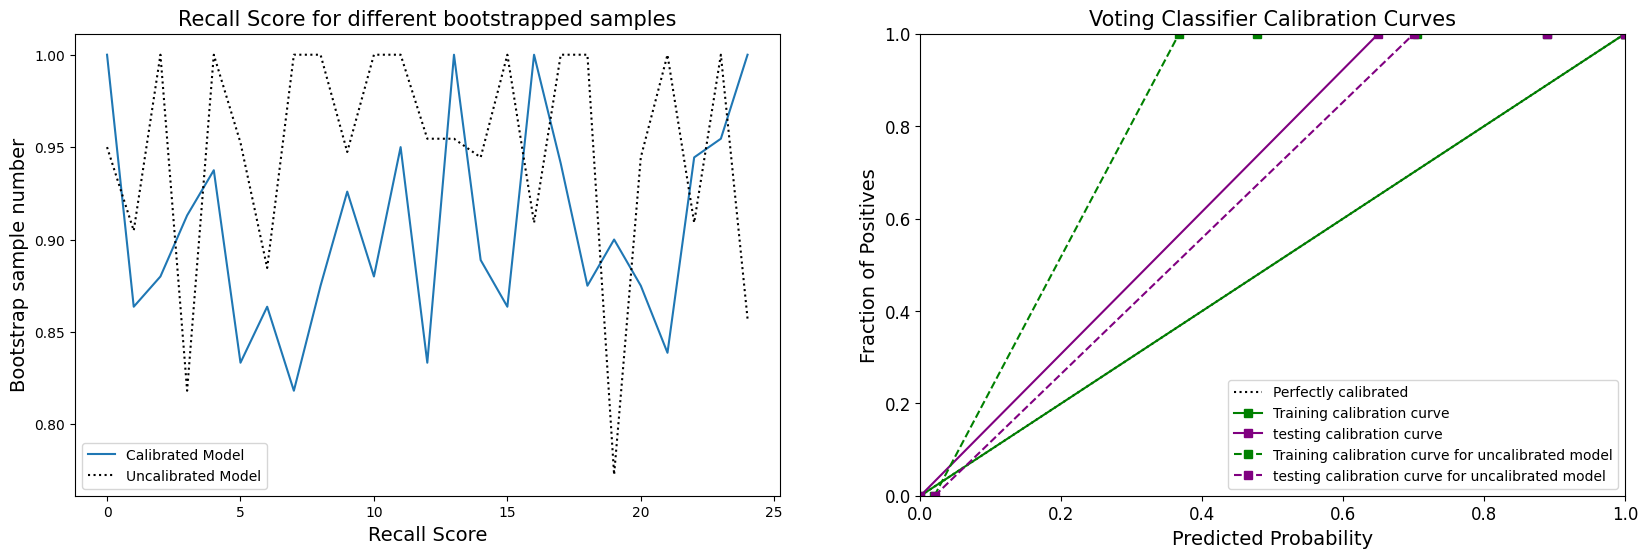

In [18]:
plt.figure(figsize = (20, 6))
plt.subplot(1,2,1)
plt.plot(vce_scores_reb_cali, label = 'Calibrated Model')
plt.plot(vce_scores_reb, 'k:', label = 'Uncalibrated Model')
plt.xlabel('Recall Score', size = 14)
plt.ylabel('Bootstrap sample number', size = 14)
plt.title('Recall Score for different bootstrapped samples', size = 15)
plt.legend()
plt.subplot(1,2,2)
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(mpv_train, fop_train, "s-", color = 'green', label = 'Training calibration curve')
plt.plot(mpv_test, fop_test, "s-", color = 'purple', label = 'testing calibration curve')
plt.plot(mpv_train_uncal, fop_train_uncal, "s-", linestyle = 'dashed', color = 'green', label = 'Training calibration curve for uncalibrated model')
plt.plot(mpv_test_uncal, fop_test_uncal, "s-", linestyle = 'dashed', color = 'purple', label = 'testing calibration curve for uncalibrated model')
plt.title('Voting Classifier Calibration Curves', size = 15, loc = 'center', wrap = True)
plt.xlabel('Predicted Probability', size = 14)
plt.ylabel('Fraction of Positives', size = 14)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.legend()

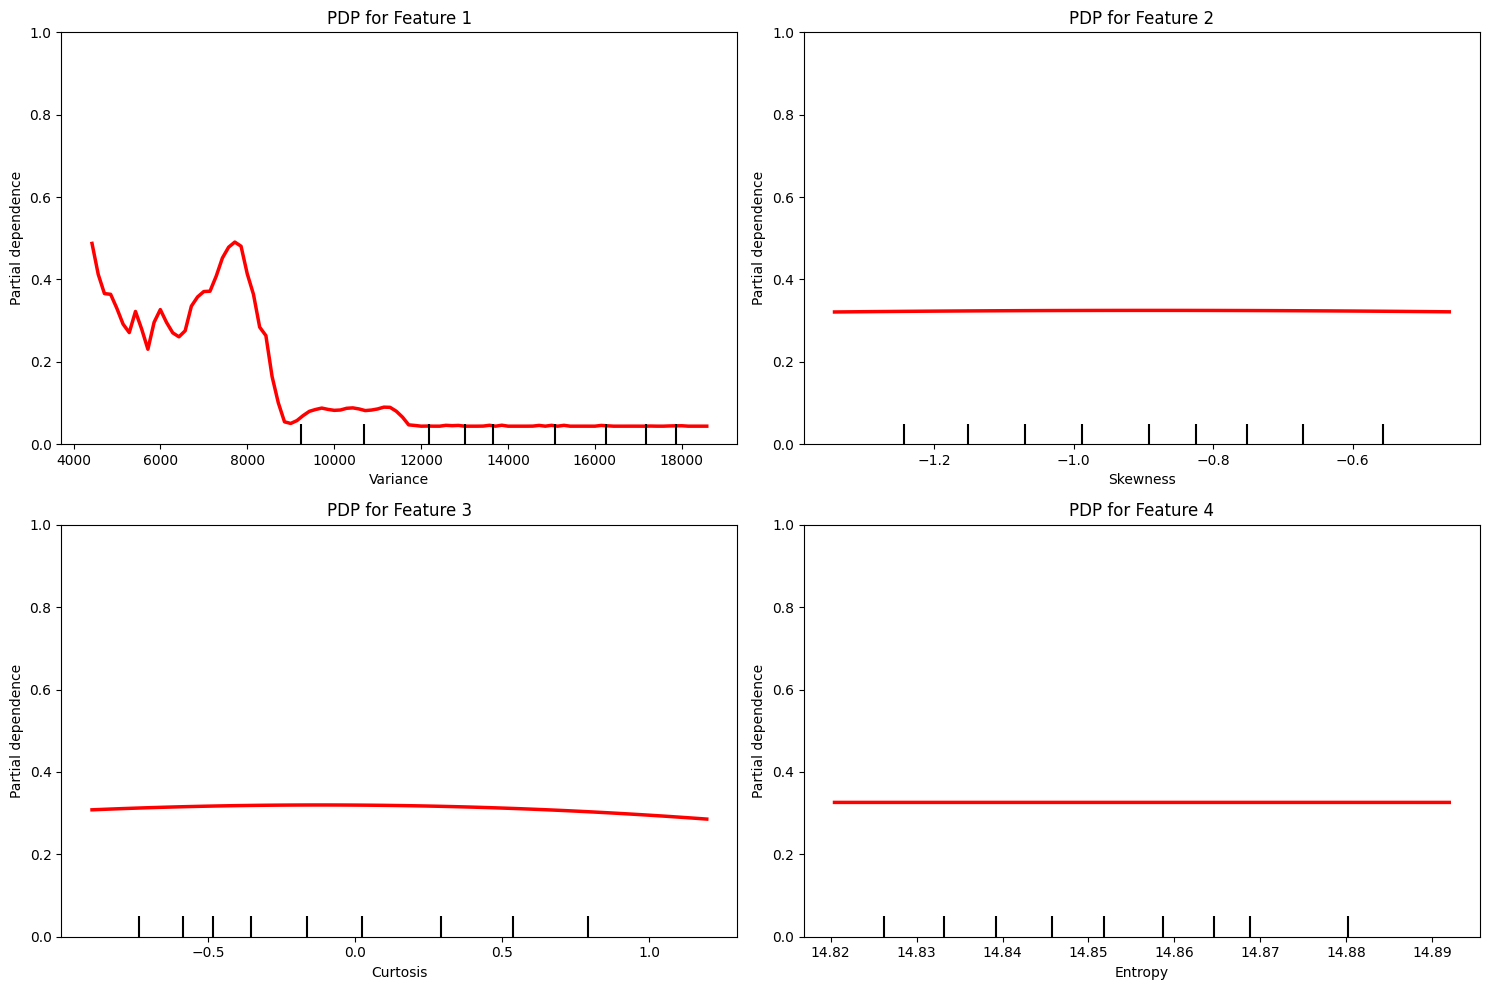

In [19]:
from sklearn.inspection import PartialDependenceDisplay

# Assuming clf_cali_pdp and best_voting_clf are already configured and X_reb, y_reb are available
clf_cali_pdp = CalibratedClassifierCV(best_voting_clf, method="isotonic")
clf_cali_pdp.fit(X_reb, y_reb)

# Define features to investigate
features = [1, 2, 3, 4]  # Indices should match meaningful features in X_reb

fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # Adjust subplots layout and figure size
axs = axs.flatten()  # Flatten the array of axes

# Generate PDP for each feature and plot in its respective subplot
for i, feature in enumerate(features):
    disp = PartialDependenceDisplay.from_estimator(
        clf_cali_pdp, X_reb, features=[feature],
        ax=axs[i], line_kw={"color": "red", "linewidth": 2.5}  # Customize line properties
    )
    axs[i].set_title(f'PDP for Feature {feature}')  # Set title for each subplot
    axs[i].set_xlabel('Feature Value')  # Set x-label
    axs[i].set_ylabel('Partial Dependence')  # Set y-label
    axs[i].grid(True)  # Add grid for easier interpretation
    axs[i].set_ylim(0, 1)  # Enforce y-axis limits after creating the plot
    plt.ylim(0,1.0)


plt.ylim(0,1.0)
plt.tight_layout()
plt.show()